In [ ]:
import numpy as np
import anndata as ad

# adata是原始AnnData对象
# 假设要合成的点位索引在python列表indices中

# 计算坐标的平均值
coords_mean = np.mean(adata.obsm['spatial'][indices, :], axis=0)

# 合并基因表达数据，这里我们取平均值
expr_mean = np.mean(adata.X[indices, :], axis=0)

# 创建一个新的点位数据矩阵和坐标矩阵
new_data_matrix = np.vstack([adata.X, expr_mean])
new_spatial_coords = np.vstack([adata.obsm['spatial'], coords_mean])

# 创建一个新的AnnData对象或更新原有对象
# 这里创建一个新的示例
new_adata = ad.AnnData(X=new_data_matrix)
new_adata.obsm['spatial'] = new_spatial_coords

# 如果有其他注释需要复制，也可以在这里操作
# 例如，复制基因名
new_adata.var_names = adata.var_names

# 注意，合成点位后可能需要更新.obs等其他注释


In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import anndata as ad


""" def reduce_cell(slice:ad.AnnData):
    # 假设slice是原始的AnnData对象

    # 计算空间点位的距离矩阵
    coords = slice.obsm['spatial']
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    # 初始化新的数据结构
    new_coords = []
    new_data_matrix = []

    # 对于每组最近邻，计算坐标和基因表达的均值
    for idx_group in indices:
        # 计算坐标的均值
        group_coords = coords[idx_group].mean(axis=0)
        new_coords.append(group_coords)
        
        # 计算基因表达的均值
        group_expr = slice.X[idx_group].mean(axis=0)
        new_data_matrix.append(group_expr)

    # 将列表转换为numpy数组
    new_coords = np.array(new_coords)
    new_data_matrix = np.vstack(new_data_matrix)

    # 创建新的AnnData对象
    new_slice = ad.AnnData(X=new_data_matrix)
    new_slice.obsm['spatial'] = new_coords
    new_slice.var_names = slice.var_names

    print(new_slice.obsm['spatial'])
    print(new_slice.X) """


data_matrix = np.random.randint(0,3,size=(30,3))
print(data_matrix)
slice = ad.AnnData(X=data_matrix)
slice.obsm['spatial'] = np.random.randint(0,10,size=(30,2))
print(slice.obsm['spatial'])   


[[0 0 0]
 [1 2 2]
 [1 0 2]
 [1 0 0]
 [1 1 0]
 [1 0 2]
 [1 2 2]
 [1 0 0]
 [2 0 1]
 [0 2 0]
 [1 2 1]
 [0 2 2]
 [1 0 1]
 [0 2 1]
 [1 1 2]
 [1 0 0]
 [1 1 0]
 [2 2 0]
 [1 0 2]
 [1 1 0]
 [2 1 0]
 [1 1 2]
 [1 0 0]
 [1 0 2]
 [2 2 0]
 [2 1 0]
 [1 1 0]
 [0 0 1]
 [2 0 1]
 [2 0 1]]
[[8 7]
 [5 8]
 [7 4]
 [6 6]
 [2 4]
 [3 8]
 [7 2]
 [6 2]
 [9 7]
 [2 6]
 [1 7]
 [5 4]
 [5 2]
 [9 6]
 [5 8]
 [4 6]
 [6 8]
 [7 3]
 [7 7]
 [0 9]
 [4 4]
 [7 4]
 [7 6]
 [1 1]
 [1 4]
 [9 2]
 [9 1]
 [3 0]
 [9 4]
 [2 2]]


In [4]:
import numpy as np
from sklearn.cluster import KMeans
import anndata as ad


def reduce_cell(slice:ad.AnnData):
    # 计算聚类数（大约每10个点位形成一个聚类）
    n_clusters = max(len(slice) // 10, 1) # 确保至少有一个聚类

    # 应用k-means聚类
    coords = slice.obsm['spatial']
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)

    # 初始化新的数据结构
    new_coords = np.zeros((n_clusters, coords.shape[1]))
    new_data_matrix = np.zeros((n_clusters, slice.X.shape[1]))

    # 对于每个聚类，计算坐标和基因表达的均值
    for i in range(n_clusters):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        new_coords[i] = coords[cluster_indices].mean(axis=0)
        new_data_matrix[i] = slice.X[cluster_indices].mean(axis=0)

    # 创建新的AnnData对象
    new_slice = ad.AnnData(X=new_data_matrix)
    new_slice.obsm['spatial'] = new_coords
    new_slice.var_names = slice.var_names

    #print(new_slice.obsm['spatial'])
    #print(new_slice.X)
    return new_slice


Using selected backend cpu. If you want to use gpu, set use_gpu = True.


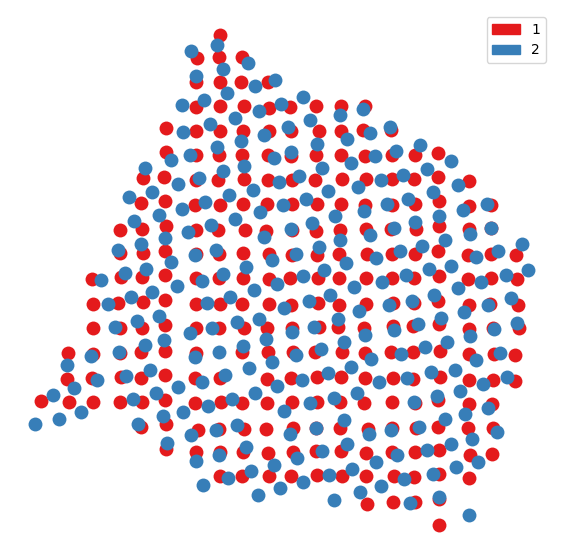

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Filtered all slices for common genes. There are 7224 common genes.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Iteration: 0
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  -27.24649219750883
Difference: 27.24649219750883

Iteration: 1
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  1.3415247267431796
Difference: 28.58801692425201

Iteration: 2
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  1.3416433559539787
Difference: 0.00011862921079908162



c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scanpy as sc
import paste as pst

# Load Slices
data_dir = '../sample_data/' # change this path to the data you wish to analyze

# Assume that the coordinates of slices are named slice_name + "_coor.csv"
def load_slices(data_dir, slice_names=["slice1", "slice2"]):
    slices = []  
    for slice_name in slice_names:
        slice_i = sc.read_csv(data_dir + slice_name + ".csv")
        slice_i_coor = np.genfromtxt(data_dir + slice_name + "_coor.csv", delimiter = ',')
        slice_i.obsm['spatial'] = slice_i_coor
        # Preprocess slices
        sc.pp.filter_genes(slice_i, min_counts = 15)
        sc.pp.filter_cells(slice_i, min_counts = 100)
        slices.append(slice_i)
    return slices

slices = load_slices(data_dir)
slice1, slice2 = slices

# Pairwise align the slices
pi12 = pst.pairwise_align(slice1, slice2)

# To visualize the alignment you can stack the slices 
# according to the alignment pi
slices, pis = [slice1, slice2], [pi12]
new_slices = pst.stack_slices_pairwise(slices, pis)

slice_colors = ['#e41a1c','#377eb8']
plt.figure(figsize=(7,7))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

# Center align slices
## We have to reload the slices as pairwise_alignment modifies the slices.
slices = load_slices(data_dir)
slice1, slice2 = slices

# Construct a center slice
## choose one of the slices as the coordinate reference for the center slice,
## i.e. the center slice will have the same number of spots as this slice and
## the same coordinates.
initial_slice = slice1.copy()    
slices = [slice1, slice2]
lmbda = len(slices)*[1/len(slices)] # set hyperparameter to be uniform

## Possible to pass in an initial pi (as keyword argument pis_init) 
## to improve performance, see Tutorial.ipynb notebook for more details.
center_slice, pis = pst.center_align(initial_slice, slices, lmbda) 

## The low dimensional representation of our center slice is held 
## in the matrices W and H, which can be used for downstream analyses
W = center_slice.uns['paste_W']
H = center_slice.uns['paste_H']

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


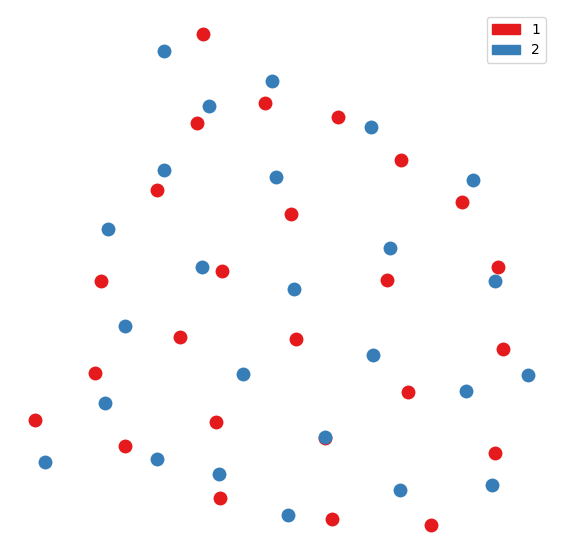

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Filtered all slices for common genes. There are 7224 common genes.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Iteration: 0
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  -27.250554711639253
Difference: 27.250554711639253

Iteration: 1
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  1.345780330184105
Difference: 28.59633504182336

Iteration: 2
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  1.3431527365046432
Difference: 0.0026275936794617483

Iteration: 3
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  1.3425940815603674
Difference: 0.0005586549442757605



c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scanpy as sc
import paste as pst

# Load Slices
data_dir = '../sample_data/' # change this path to the data you wish to analyze

# Assume that the coordinates of slices are named slice_name + "_coor.csv"
def load_slices(data_dir, slice_names=["slice1", "slice2"]):
    slices = []  
    for slice_name in slice_names:
        slice_i = sc.read_csv(data_dir + slice_name + ".csv")
        slice_i_coor = np.genfromtxt(data_dir + slice_name + "_coor.csv", delimiter = ',')
        slice_i.obsm['spatial'] = slice_i_coor
        # Preprocess slices
        sc.pp.filter_genes(slice_i, min_counts = 15)
        sc.pp.filter_cells(slice_i, min_counts = 100)
        slices.append(slice_i)
    return slices

slices = load_slices(data_dir)
slice1, slice2 = slices
#细胞缩点
slice1 = reduce_cell(slice1)
slice2 = reduce_cell(slice2)

# Pairwise align the slices
pi12 = pst.pairwise_align(slice1, slice2)

# To visualize the alignment you can stack the slices 
# according to the alignment pi
slices, pis = [slice1, slice2], [pi12]
new_slices = pst.stack_slices_pairwise(slices, pis)

slice_colors = ['#e41a1c','#377eb8']
plt.figure(figsize=(7,7))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),mpatches.Patch(color=slice_colors[1], label='2')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

# Center align slices
## We have to reload the slices as pairwise_alignment modifies the slices.
slices = load_slices(data_dir)
slice1, slice2 = slices

# Construct a center slice
## choose one of the slices as the coordinate reference for the center slice,
## i.e. the center slice will have the same number of spots as this slice and
## the same coordinates.
initial_slice = slice1.copy()    
slices = [slice1, slice2]
lmbda = len(slices)*[1/len(slices)] # set hyperparameter to be uniform

## Possible to pass in an initial pi (as keyword argument pis_init) 
## to improve performance, see Tutorial.ipynb notebook for more details.
center_slice, pis = pst.center_align(initial_slice, slices, lmbda) 

## The low dimensional representation of our center slice is held 
## in the matrices W and H, which can be used for downstream analyses
W = center_slice.uns['paste_W']
H = center_slice.uns['paste_H']